# SEED

Semantic Evaluation Dataset

## 1. Imports

In [1]:
import json
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from google import genai

from seed.config import PROCESSED_DIR, SEED_PATH

In [2]:
load_dotenv()

True

In [3]:
plt.rcParams["axes.grid"] = False

## 2. Data Loading

In [4]:
data = []

with SEED_PATH.open() as file:
    for line in file:
        lemma = json.loads(line)

        for sense in lemma["senses"]:
            sentences = sense.get("sentences", [])
            translations = sense.get("translations", [])

            data.append(
                {
                    "lemma": lemma["lemma"],
                    "definition": sense["definition"],
                    "sentences": sentences or None,
                    "sentence_count": len(sentences),
                    "translations": translations or None,
                    "translation_count": len(translations),
                }
            )

df = pd.DataFrame(data)

## 3. Exploratory Data Analysis

### 3.1. Data Overview

In [5]:
df.head()

,lemma,definition,sentences,sentence_count,translations,translation_count
0,dictionary,A reference work listing words or names from o...,"[If you want to know the meaning of a word, lo...",1,None,0
1,dictionary,A reference work on a particular subject or ac...,"[a law dictionary, a dictionary of sports]",2,None,0
2,dictionary,A synchronic dictionary of a standardised lang...,[By 1986 the name Walkman was included as a wo...,1,None,0
3,dictionary,"An associative array, a data structure where e...","[User calls RouteCollection.GetVirtualPath, pa...",1,None,0
4,dictionary,To add to a dictionary.,[Should I use a word that a lot of people use ...,1,None,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247628 entries, 0 to 247627
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   lemma              247628 non-null  object
 1   definition         247628 non-null  object
 2   sentences          247628 non-null  object
 3   sentence_count     247628 non-null  int64 
 4   translations       35852 non-null   object
 5   translation_count  247628 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 11.3+ MB


In [7]:
df.drop(columns=["sentences", "translations"]).describe(include="all")

,lemma,definition,sentence_count,translation_count
count,247628,247628,247628.000000,247628.000000
unique,176551,233555,NaN,NaN
top,take,A surname.,NaN,NaN
freq,83,541,NaN,NaN
mean,NaN,NaN,1.679818,3.215161
std,NaN,NaN,1.187097,15.285583
min,NaN,NaN,1.000000,0.000000
25%,NaN,NaN,1.000000,0.000000
50%,NaN,NaN,1.000000,0.000000
75%,NaN,NaN,2.000000,0.000000


### 3.2. Visualizations

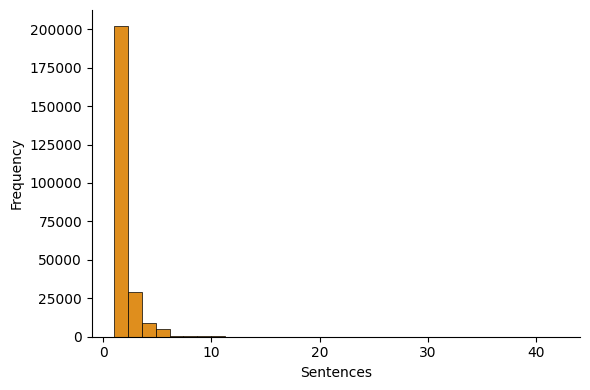

In [8]:
plt.figure(figsize=(6, 4))

plt.hist(
    df["sentence_count"],
    bins=32,
    color="#df8e1d",
    edgecolor="black",
    linewidth=0.5,
)

ax = plt.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xlabel("Sentences")
plt.ylabel("Frequency")

plt.savefig(
    "../reports/figures/sentence_distribution.png",
    dpi=300,
    bbox_inches="tight",
)

plt.tight_layout()
plt.show()

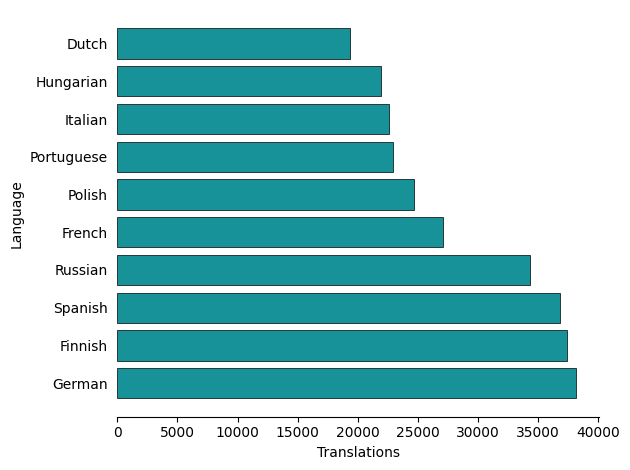

In [9]:
languages = (
    df["translations"]
    .explode()
    .dropna()
    .apply(lambda translation: translation["language"])
    .str.capitalize()
    .value_counts()
    .head(10)
)

plt.barh(
    languages.index,
    languages.values,
    color="#179299",
    edgecolor="black",
    linewidth=0.5,
)

ax = plt.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.tick_params(left=False)

plt.xlabel("Translations")
plt.ylabel("Language")

plt.savefig(
    "../reports/figures/language_distribution.png",
    dpi=300,
    bbox_inches="tight",
)

plt.tight_layout()
plt.show()

## 4. Evaluating

In [10]:
TARGET_LANGUAGE = "italian"

### 4.1. Sample Selection

In [11]:
rng = np.random.default_rng(42)

samples = (
    df[
        df["sentences"].notna()
        & df["sentences"].apply(lambda sentences: len(sentences) > 0)
        & df["translations"].notna()
    ]
    .assign(
        sentence=lambda lemma: lemma["sentences"].apply(
            lambda sentences: rng.choice(sentences)
        ),
        translation=lambda lemma: lemma["translations"].apply(
            lambda translations: next(
                (
                    translation["translation"]
                    for translation in translations
                    if translation["language"] == TARGET_LANGUAGE
                ),
                None,
            )
        ),
    )
    .dropna(subset=["translation"])
    .sample(n=100, random_state=42)
    .reset_index(drop=True)
)[["lemma", "definition", "sentence", "translation"]]

### 4.2. LLM Generation

In [12]:
MODEL = "gemma-3-27b-it"

BATCH_SIZE = 30
DELAY = 60

In [13]:
PARAPHRASE_PROMPT_TEMPLATE = 'Read the sentence: "{sentence}". Rewrite the entire sentence using different words while strictly preserving the original meaning. Provide as output only the paraphrased text.'
TRANSLATE_PROMPT_TEMPLATE = 'Read the sentence: "{sentence}". Translate the sentence into {target_language}. Provide as output only the translated sentence.'

In [14]:
client = genai.Client()

paraphrases = []
translations = []

request_count = 0

for _, row in samples.iterrows():
    if request_count > 0 and request_count % BATCH_SIZE == 0:
        time.sleep(DELAY)
        
    response = client.models.generate_content(
        model=MODEL,
        contents=PARAPHRASE_PROMPT_TEMPLATE.format(
            sentence=row["sentence"],
        ),
    )

    paraphrases.append(response.text)
    request_count += 1

    response = client.models.generate_content(
        model=MODEL,
        contents=TRANSLATE_PROMPT_TEMPLATE.format(
            sentence=row["sentence"],
            target_language=TARGET_LANGUAGE,
        ),
    )

    translations.append(response.text)
    request_count += 1

samples["generated_paraphrase"] = paraphrases
samples["generated_translation"] = translations

### 4.3. Save results

In [44]:
samples.to_csv(PROCESSED_DIR / "samples.csv", index=False)